In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer



In [2]:
# Load solar generation data
solar_df = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")
# Load weather data
weather_df = pd.read_csv("datasets/Meteorologia.csv", sep=",")
consumption= pd.read_csv("datasets/Consumo_sept.csv", sep=",")


In [3]:
# Check shape and preview
print(solar_df.shape)
print(solar_df.head())
print(solar_df.tail())

print(weather_df.shape)
print(weather_df.tail())

(9708, 2)
                 FECHA  TOTAL_KWH_ENERGIA
0  2023-07-24 11:00:00                NaN
1  2023-07-24 12:00:00             115.66
2  2023-07-24 13:00:00             129.98
3  2023-07-24 14:00:00             134.35
4  2023-07-24 15:00:00             133.90
                    FECHA  TOTAL_KWH_ENERGIA
9703  2024-08-31 19:00:00                NaN
9704  2024-08-31 20:00:00                NaN
9705  2024-08-31 21:00:00                NaN
9706  2024-08-31 22:00:00                NaN
9707  2024-08-31 23:00:00                NaN
(100557, 27)
               FORECAST_TIMESTAMP  LATITUDE  LONGITUDE  \
100552  2024-10-31 19:00:00+00:00      40.5       -3.5   
100553  2024-10-31 20:00:00+00:00      40.5       -3.5   
100554  2024-10-31 21:00:00+00:00      40.5       -3.5   
100555  2024-10-31 22:00:00+00:00      40.5       -3.5   
100556  2024-10-31 23:00:00+00:00      40.5       -3.5   

        10uheightAboveGround_10  10vheightAboveGround_10  \
100552                -1.515610               

In [4]:
solar_df.rename(columns={'FECHA': 'Datetime','TOTAL_KWH_ENERGIA': 'KWH_ENERGIA'}, inplace=True)

weather_df.rename(columns={'FORECAST_TIMESTAMP': 'Datetime'}, inplace=True)

In [5]:
# Convert solar datetime to timezone-aware if needed
solar_df['Datetime'] = pd.to_datetime(solar_df['Datetime'])

# Weather is in UTC → convert to Europe/Madrid
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'])
weather_df['Datetime'] = weather_df['Datetime'].dt.tz_convert('Europe/Madrid')

# Remove tz info to match solar_df
weather_df['Datetime'] = weather_df['Datetime'].dt.tz_localize(None)

In [6]:
solar_df['hour'] = solar_df['Datetime'].dt.hour
solar_df['day'] = solar_df['Datetime'].dt.day
solar_df['month'] = solar_df['Datetime'].dt.month
solar_df['year'] = solar_df['Datetime'].dt.year
solar_df['weekday'] = solar_df['Datetime'].dt.weekday  # Monday=0, Sunday=6

In [7]:
weather_df['Datetime'].dt.tz is not None

False

In [8]:
# Check for missing values
print("Solar missing:\n", solar_df.isnull().sum())

Solar missing:
 Datetime          0
KWH_ENERGIA    1164
hour              0
day               0
month             0
year              0
weekday           0
dtype: int64


In [9]:
print("Weather missing:\n", weather_df.isnull().sum())

Weather missing:
 Datetime                        0
LATITUDE                        0
LONGITUDE                       0
10uheightAboveGround_10         0
10vheightAboveGround_10         0
2rheightAboveGround_2           0
2shheightAboveGround_2          0
2theightAboveGround_2           0
SUNSDsurface_0                  1
aptmpheightAboveGround_2        0
dlwrfsurface_0                  0
dswrfsurface_0                  0
gustsurface_0                   0
msletmeanSea_0                  0
presheightAboveGround_80        0
pwatatmosphereSingleLayer_0     0
qheightAboveGround_80           0
spsurface_0                     0
tccatmosphere_0                 0
theightAboveGround_80           0
tmaxheightAboveGround_2         0
tminheightAboveGround_2         0
tozneatmosphereSingleLayer_0    0
tpsurface_0                     0
tsurface_0                      0
uheightAboveGround_80           0
vheightAboveGround_80           0
dtype: int64


In [10]:
print(weather_df['Datetime'].head())


0   2023-07-24 13:00:00
1   2023-07-24 14:00:00
2   2023-07-24 15:00:00
3   2023-07-24 16:00:00
4   2023-07-24 17:00:00
Name: Datetime, dtype: datetime64[ns]


In [11]:
# Check for missing values
print("Solar missing:\n", solar_df.isnull().sum())
print("Weather missing:\n", weather_df.isnull().sum())

#Check for 0 or negative solar generation
print(solar_df['KWH_ENERGIA'].describe())
print("Zero values:", (solar_df['KWH_ENERGIA'] == 0).sum())

Solar missing:
 Datetime          0
KWH_ENERGIA    1164
hour              0
day               0
month             0
year              0
weekday           0
dtype: int64
Weather missing:
 Datetime                        0
LATITUDE                        0
LONGITUDE                       0
10uheightAboveGround_10         0
10vheightAboveGround_10         0
2rheightAboveGround_2           0
2shheightAboveGround_2          0
2theightAboveGround_2           0
SUNSDsurface_0                  1
aptmpheightAboveGround_2        0
dlwrfsurface_0                  0
dswrfsurface_0                  0
gustsurface_0                   0
msletmeanSea_0                  0
presheightAboveGround_80        0
pwatatmosphereSingleLayer_0     0
qheightAboveGround_80           0
spsurface_0                     0
tccatmosphere_0                 0
theightAboveGround_80           0
tmaxheightAboveGround_2         0
tminheightAboveGround_2         0
tozneatmosphereSingleLayer_0    0
tpsurface_0                    

In [12]:
weather_df.isnull().sum()


Datetime                        0
LATITUDE                        0
LONGITUDE                       0
10uheightAboveGround_10         0
10vheightAboveGround_10         0
2rheightAboveGround_2           0
2shheightAboveGround_2          0
2theightAboveGround_2           0
SUNSDsurface_0                  1
aptmpheightAboveGround_2        0
dlwrfsurface_0                  0
dswrfsurface_0                  0
gustsurface_0                   0
msletmeanSea_0                  0
presheightAboveGround_80        0
pwatatmosphereSingleLayer_0     0
qheightAboveGround_80           0
spsurface_0                     0
tccatmosphere_0                 0
theightAboveGround_80           0
tmaxheightAboveGround_2         0
tminheightAboveGround_2         0
tozneatmosphereSingleLayer_0    0
tpsurface_0                     0
tsurface_0                      0
uheightAboveGround_80           0
vheightAboveGround_80           0
dtype: int64

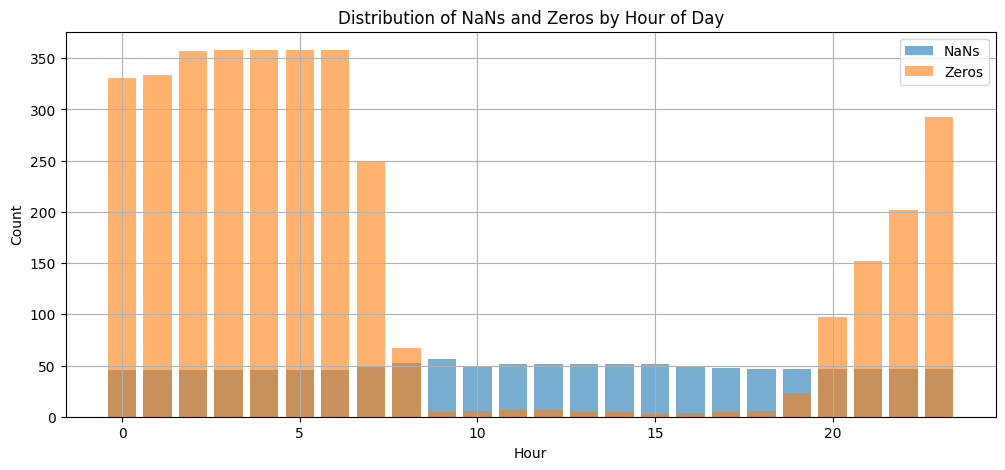

In [13]:
import matplotlib.pyplot as plt

# Count NaNs by hour of the day
nan_by_hour = solar_df[solar_df['KWH_ENERGIA'].isna()]['hour'].value_counts().sort_index()
zero_by_hour = solar_df[solar_df['KWH_ENERGIA'] == 0]['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
plt.bar(nan_by_hour.index, nan_by_hour.values, alpha=0.6, label='NaNs')
plt.bar(zero_by_hour.index, zero_by_hour.values, alpha=0.6, label='Zeros')
plt.title("Distribution of NaNs and Zeros by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

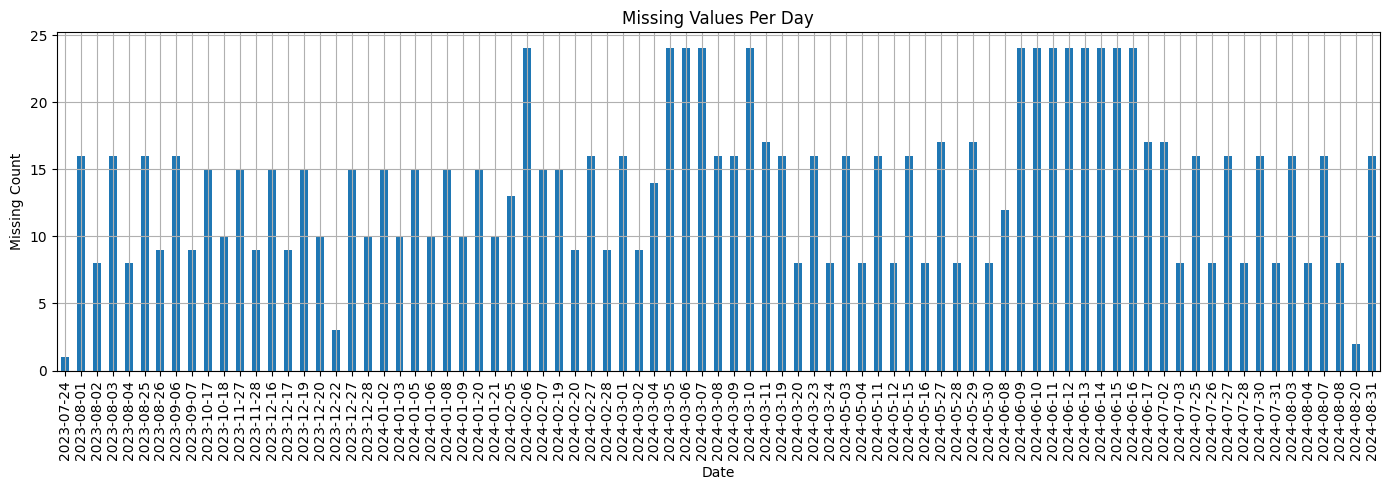

In [14]:
# Count missing values per day
solar_df['date'] = solar_df['Datetime'].dt.date
nan_per_day = solar_df[solar_df['KWH_ENERGIA'].isna()].groupby('date').size()

plt.figure(figsize=(14, 5))
nan_per_day.plot(kind='bar')
plt.title("Missing Values Per Day")
plt.xlabel("Date")
plt.ylabel("Missing Count")
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

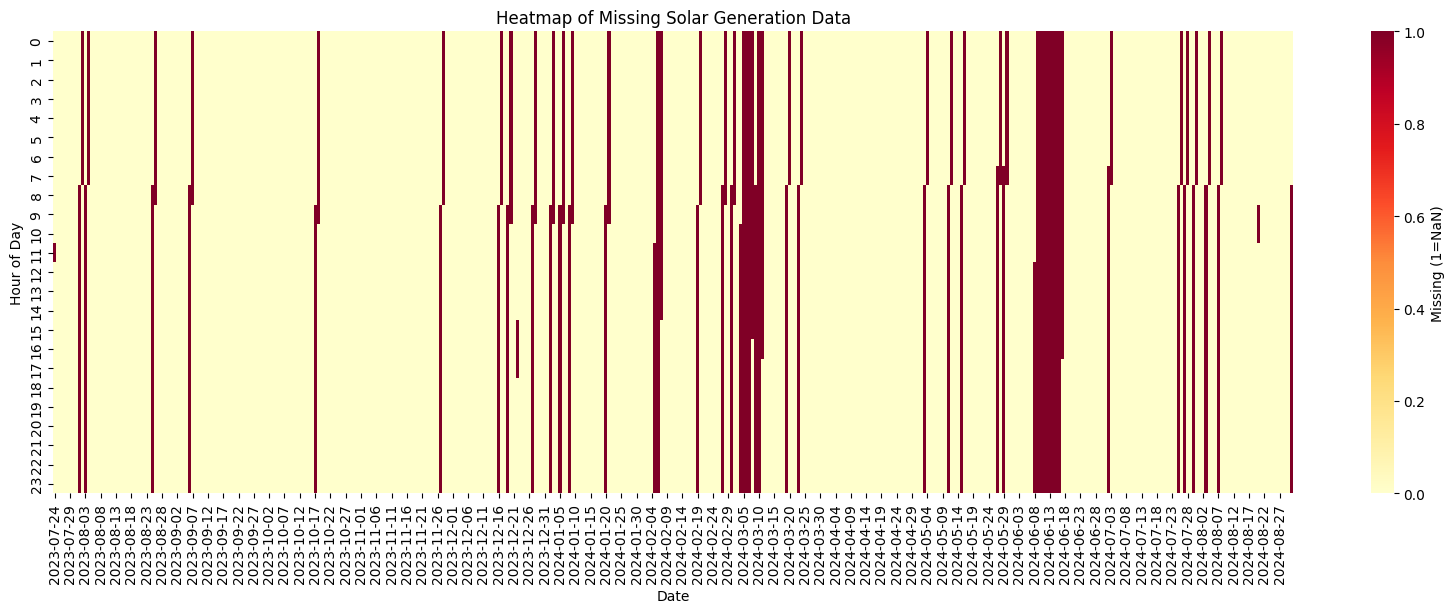

In [15]:
import seaborn as sns

# Create a pivot table to see missing per hour per day
heat_df = solar_df.copy()
heat_df['hour'] = heat_df['Datetime'].dt.hour
heat_df['date'] = heat_df['Datetime'].dt.date
heat_df['missing'] = heat_df['KWH_ENERGIA'].isna().astype(int)

pivot = heat_df.pivot_table(index='hour', columns='date', values='missing', fill_value=0)

plt.figure(figsize=(20, 6))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Missing (1=NaN)'})
plt.title("Heatmap of Missing Solar Generation Data")
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.show()

In [16]:
print(solar_df.isnull().mean().sort_values(ascending=False))

KWH_ENERGIA    0.119901
Datetime       0.000000
hour           0.000000
day            0.000000
month          0.000000
year           0.000000
weekday        0.000000
date           0.000000
dtype: float64


In [17]:
print(weather_df.isnull().mean().sort_values(ascending=False))

SUNSDsurface_0                  0.00001
LATITUDE                        0.00000
Datetime                        0.00000
LONGITUDE                       0.00000
10uheightAboveGround_10         0.00000
2rheightAboveGround_2           0.00000
10vheightAboveGround_10         0.00000
2shheightAboveGround_2          0.00000
2theightAboveGround_2           0.00000
aptmpheightAboveGround_2        0.00000
dlwrfsurface_0                  0.00000
dswrfsurface_0                  0.00000
gustsurface_0                   0.00000
msletmeanSea_0                  0.00000
presheightAboveGround_80        0.00000
pwatatmosphereSingleLayer_0     0.00000
qheightAboveGround_80           0.00000
spsurface_0                     0.00000
tccatmosphere_0                 0.00000
theightAboveGround_80           0.00000
tmaxheightAboveGround_2         0.00000
tminheightAboveGround_2         0.00000
tozneatmosphereSingleLayer_0    0.00000
tpsurface_0                     0.00000
tsurface_0                      0.00000


In [18]:
solar_df1 = solar_df.copy()

# Define daylight hours
solar_df1['hour'] = solar_df1['Datetime'].dt.hour
solar_df1['is_daylight'] = solar_df1['hour'].between(6, 20)

# Fill NaNs at night with 0
solar_df1.loc[(solar_df1['KWH_ENERGIA'].isna()) & (~solar_df1['is_daylight']), 'KWH_ENERGIA'] = 0

# Drop remaining NaNs (daytime sensor errors)
solar_df1 = solar_df1[~solar_df1['KWH_ENERGIA'].isna()]

In [19]:
solar_df2 = solar_df.copy()

# Set Datetime as index
solar_df2.set_index('Datetime', inplace=True)

# Now interpolate
solar_df2['KWH_ENERGIA'] = solar_df2['KWH_ENERGIA'].interpolate(method='time')

# Optional: Drop any NaNs still left at edges
solar_df2 = solar_df2.dropna(subset=['KWH_ENERGIA'])

# Reset index to bring 'Datetime' back as a column
solar_df2 = solar_df2.reset_index()


In [20]:
# Merge method for any df
def merge_solar_weather(solar_df, weather_df):
    solar_df['Datetime'] = pd.to_datetime(solar_df['Datetime']).dt.round('H')
    weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime']).dt.round('H')
    
    merged = pd.merge(solar_df, weather_df, on='Datetime', how='inner')
    return merged

In [21]:
merged_df1 = merge_solar_weather(solar_df1, weather_df)
merged_df2 = merge_solar_weather(solar_df2, weather_df)

C:\Users\dario\AppData\Local\Temp\ipykernel_13772\1848125610.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  solar_df['Datetime'] = pd.to_datetime(solar_df['Datetime']).dt.round('H')
C:\Users\dario\AppData\Local\Temp\ipykernel_13772\1848125610.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime']).dt.round('H')
C:\Users\dario\AppData\Local\Temp\ipykernel_13772\1848125610.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  solar_df['Datetime'] = pd.to_datetime(solar_df['Datetime']).dt.round('H')
C:\Users\dario\AppData\Local\Temp\ipykernel_13772\1848125610.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime']).dt.round('H')


In [22]:
weather_df.columns.tolist()


['Datetime',
 'LATITUDE',
 'LONGITUDE',
 '10uheightAboveGround_10',
 '10vheightAboveGround_10',
 '2rheightAboveGround_2',
 '2shheightAboveGround_2',
 '2theightAboveGround_2',
 'SUNSDsurface_0',
 'aptmpheightAboveGround_2',
 'dlwrfsurface_0',
 'dswrfsurface_0',
 'gustsurface_0',
 'msletmeanSea_0',
 'presheightAboveGround_80',
 'pwatatmosphereSingleLayer_0',
 'qheightAboveGround_80',
 'spsurface_0',
 'tccatmosphere_0',
 'theightAboveGround_80',
 'tmaxheightAboveGround_2',
 'tminheightAboveGround_2',
 'tozneatmosphereSingleLayer_0',
 'tpsurface_0',
 'tsurface_0',
 'uheightAboveGround_80',
 'vheightAboveGround_80']

In [23]:
# Merge solar + weather (cleaned)
merged = pd.merge(solar_df1, weather_df, on='Datetime', how='inner')

# Compute correlations with target
corr = merged.corr(numeric_only=True)['KWH_ENERGIA'].sort_values(ascending=False)
print(corr)


KWH_ENERGIA                     1.000000e+00
dswrfsurface_0                  7.271273e-01
tsurface_0                      5.809983e-01
SUNSDsurface_0                  5.485263e-01
is_daylight                     4.978934e-01
2theightAboveGround_2           3.579617e-01
aptmpheightAboveGround_2        3.478628e-01
hour                            2.656038e-01
theightAboveGround_80           2.631939e-01
tmaxheightAboveGround_2         2.575227e-01
tminheightAboveGround_2         2.052189e-01
dlwrfsurface_0                  1.266441e-01
10vheightAboveGround_10         5.762297e-02
year                            5.740295e-02
10uheightAboveGround_10         5.572013e-02
vheightAboveGround_80           4.536921e-02
tozneatmosphereSingleLayer_0    3.075245e-02
day                             2.814591e-02
presheightAboveGround_80        2.582825e-02
uheightAboveGround_80           2.560332e-02
spsurface_0                     1.877964e-02
LATITUDE                        7.640879e-14
LONGITUDE 

In [24]:
# Choose numeric weather features automatically (excluding 'Datetime' and 'LATITUDE', 'LONGITUDE')
all_weather_features = [col for col in weather_df.columns 
                        if weather_df[col].dtype in ['float64', 'int64']
                        and col not in ['LATITUDE', 'LONGITUDE']]

# Add time features
full_features = all_weather_features + ['hour', 'month', 'weekday']

# Train/test as before
X = merged[full_features]
y = merged['KWH_ENERGIA']


In [25]:
import matplotlib.pyplot as plt

# Get feature importance from your best model
importances = model1.feature_importances_
feature_names = weather_features

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.grid()
plt.show()


NameError: name 'model1' is not defined

In [ ]:
# Check correlation matrix
corr_matrix = merged_df1[weather_features + ['KWH_ENERGIA']].corr()

# Focus on correlation with the target
corr_with_target = corr_matrix['KWH_ENERGIA'].sort_values(ascending=False)
print(corr_with_target)

KWH_ENERGIA              1.000000
dswrfsurface_0           0.727127
SUNSDsurface_0           0.548526
2theightAboveGround_2    0.357962
hour                     0.265604
month                   -0.018915
gustsurface_0           -0.086110
tccatmosphere_0         -0.117171
weekday                 -0.147221
2rheightAboveGround_2   -0.391920
Name: KWH_ENERGIA, dtype: float64


In [26]:
weather_features = [
    'dswrfsurface_0',          # Direct shortwave radiation
    'tccatmosphere_0',         # Total cloud cover
    '2theightAboveGround_2',   # Air temperature at 2m
    'SUNSDsurface_0',          # Sunshine duration
    'gustsurface_0',           # Wind gusts
    '2rheightAboveGround_2',   # Relative humidity
    'hour', 'month', 'weekday' # Time-based features from Datetime
]

In [27]:
for df in [merged_df1, merged_df2]:
    df['hour'] = df['Datetime'].dt.hour
    df['month'] = df['Datetime'].dt.month
    df['weekday'] = df['Datetime'].dt.weekday

In [28]:
# Choose features + target
X1 = merged_df1[weather_features]
y1 = merged_df1['KWH_ENERGIA']

X2 = merged_df2[weather_features]
y2 = merged_df2['KWH_ENERGIA']

In [30]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Split into train/test (e.g., last month for val)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=False)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=False)

model1 = LGBMRegressor()
model2 = LGBMRegressor()

model1.fit(X1_train, y1_train)
model2.fit(X2_train, y2_train)

# Predict and evaluate
pred1 = model1.predict(X1_test)
pred2 = model2.predict(X2_test)

mae1 = mean_absolute_error(y1_test, pred1)
mae2 = mean_absolute_error(y2_test, pred2)

print("MAE (Night filled, day dropped):", round(mae1, 4))
print("MAE (Interpolated):", round(mae2, 4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 64519, number of used features: 9
[LightGBM] [Info] Start training from score 22.767760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1563
[LightGBM] [Info] Number of data points in the train set: 69890, number of used features: 9
[LightGBM] [Info] Start training from score 22.152245
MAE (Night filled, day dropped): 8.4414
MAE (Interpolated): 13.623


In [128]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Make a fresh copy
solar_hybrid = solar_df.copy()

# Set Datetime as index for time-based imputation
solar_hybrid.set_index('Datetime', inplace=True)

# Fill NaNs at night with 0
solar_hybrid['hour'] = solar_hybrid.index.hour
solar_hybrid.loc[(solar_hybrid['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7])) &
                 (solar_hybrid['KWH_ENERGIA'].isna()), 'KWH_ENERGIA'] = 0

# Use Iterative Imputer for the rest
imp = IterativeImputer(max_iter=10, random_state=42)
solar_hybrid['KWH_ENERGIA'] = imp.fit_transform(solar_hybrid[['KWH_ENERGIA']])

# Reset index
solar_hybrid = solar_hybrid.reset_index()


In [129]:
solar_hybrid['month'] = solar_hybrid['Datetime'].dt.month
solar_hybrid['day'] = solar_hybrid['Datetime'].dt.day
solar_hybrid['hour'] = solar_hybrid['Datetime'].dt.hour
solar_hybrid['weekday'] = solar_hybrid['Datetime'].dt.weekday

# Cyclical encoding for time features
solar_hybrid['hour_sin'] = np.sin(2 * np.pi * solar_hybrid['hour'] / 24)
solar_hybrid['hour_cos'] = np.cos(2 * np.pi * solar_hybrid['hour'] / 24)

solar_hybrid['month_sin'] = np.sin(2 * np.pi * solar_hybrid['month'] / 12)
solar_hybrid['month_cos'] = np.cos(2 * np.pi * solar_hybrid['month'] / 12)


In [130]:
# Ensure weather time is aligned
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime']).dt.round('H')
solar_hybrid['Datetime'] = pd.to_datetime(solar_hybrid['Datetime']).dt.round('H')

# Merge
hybrid_merged = pd.merge(solar_hybrid, weather_df, on='Datetime', how='inner')


/var/folders/0d/kg6h6hgn2rj5smljr1pqgk0r0000gn/T/ipykernel_13320/3099038940.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime']).dt.round('H')
/var/folders/0d/kg6h6hgn2rj5smljr1pqgk0r0000gn/T/ipykernel_13320/3099038940.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  solar_hybrid['Datetime'] = pd.to_datetime(solar_hybrid['Datetime']).dt.round('H')


In [131]:
# Select best features from weather + cyclical
features = [
    'dswrfsurface_0', 'tccatmosphere_0', '2theightAboveGround_2',
    'SUNSDsurface_0', 'gustsurface_0',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

X_hybrid = hybrid_merged[features]
y_hybrid = hybrid_merged['KWH_ENERGIA']


In [133]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Split
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y_hybrid, test_size=0.2, shuffle=False)

# LightGBM
lgb_model = LGBMRegressor()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Compare MAE
mae_lgb = mean_absolute_error(y_test, lgb_preds)
mae_xgb = mean_absolute_error(y_test, xgb_preds)

print("Hybrid LightGBM MAE:", round(mae_lgb, 4))
print("Hybrid XGBoost MAE:", round(mae_xgb, 4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 69890, number of used features: 9
[LightGBM] [Info] Start training from score 22.637693
Hybrid LightGBM MAE: 14.4683
Hybrid XGBoost MAE: 15.2635


In [134]:
weather_sept = weather_df[
    (weather_df['Datetime'] >= '2024-09-01') &
    (weather_df['Datetime'] < '2024-10-01')
].copy()

# Add time-based features
weather_sept['hour'] = weather_sept['Datetime'].dt.hour
weather_sept['month'] = weather_sept['Datetime'].dt.month
weather_sept['weekday'] = weather_sept['Datetime'].dt.weekday


In [135]:
weather_sept = weather_df[
    (weather_df['Datetime'] >= '2024-09-01') &
    (weather_df['Datetime'] < '2024-10-01')
].copy()

# Add time-based features
weather_sept['hour'] = weather_sept['Datetime'].dt.hour
weather_sept['month'] = weather_sept['Datetime'].dt.month
weather_sept['weekday'] = weather_sept['Datetime'].dt.weekday


In [137]:
# Use the same weather_features list you used for training
weather_features = [
    'dswrfsurface_0', 'tccatmosphere_0', '2theightAboveGround_2',
    'SUNSDsurface_0', 'gustsurface_0',
    '2rheightAboveGround_2',
    'hour', 'month', 'weekday'
]

X_sept = weather_sept[weather_features]
sept_preds = model1.predict(X_sept)  # model1 is your best LightGBM model


In [138]:
output_df = pd.DataFrame({
    'Datetime': weather_sept['Datetime'],
    'KWH_ENERGIA': sept_preds.round(4)
})

# Save to CSV
output_df.to_csv('predicted_solar_generation_september2024.csv', index=False)

In [139]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_preds)
print("Random Forest MAE:", round(mae_rf, 4))

Random Forest MAE: 14.1973


In [141]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_model = HistGradientBoostingRegressor()
hgb_model.fit(X_train, y_train)
hgb_preds = hgb_model.predict(X_test)

mae_hgb = mean_absolute_error(y_test, hgb_preds)
print("HistGradientBoosting MAE:", round(mae_hgb, 4))

HistGradientBoosting MAE: 14.6


In [150]:
best_features = [
    'dswrfsurface_0',
    'tsurface_0',
    'SUNSDsurface_0',
    '2theightAboveGround_2',
    'aptmpheightAboveGround_2',
    'theightAboveGround_80',
    'tmaxheightAboveGround_2',
    'tminheightAboveGround_2',
    'hour', 'month', 'weekday'
]


In [151]:
for df in [merged_df1, merged_df2]:
    df['hour'] = df['Datetime'].dt.hour
    df['month'] = df['Datetime'].dt.month
    df['weekday'] = df['Datetime'].dt.weekday

In [152]:
# Choose features + target
X3 = merged_df1[best_features]
y3 = merged_df1['KWH_ENERGIA']

X4 = merged_df2[best_features]
y4 = merged_df2['KWH_ENERGIA']

In [154]:
best_model_df1 = LGBMRegressor()
best_model_df2 = LGBMRegressor()

best_model_df1.fit(X3_train, y3_train)
best_model_df2.fit(X4_train, y4_train)

pred_df1 = best_model_df1.predict(X3_test)
pred_df2 = best_model_df2.predict(X4_test)

mae_df1 = mean_absolute_error(y3_test, pred_df1)
mae_df2 = mean_absolute_error(y4_test, pred_df2)

print("NEW MAE (Best Features + Night=0/Day Dropped):", round(mae_df1, 4))
print("NEW MAE (Best Features + Interpolated):", round(mae_df2, 4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 64519, number of used features: 11
[LightGBM] [Info] Start training from score 22.767760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2084
[LightGBM] [Info] Number of data points in the train set: 69890, number of used features: 11
[LightGBM] [Info] Start training from score 22.152245
NEW MAE (Best Features + Night=0/Day Dropped): 9.0026
NEW MAE (Best Features + Interpolated): 14.3947


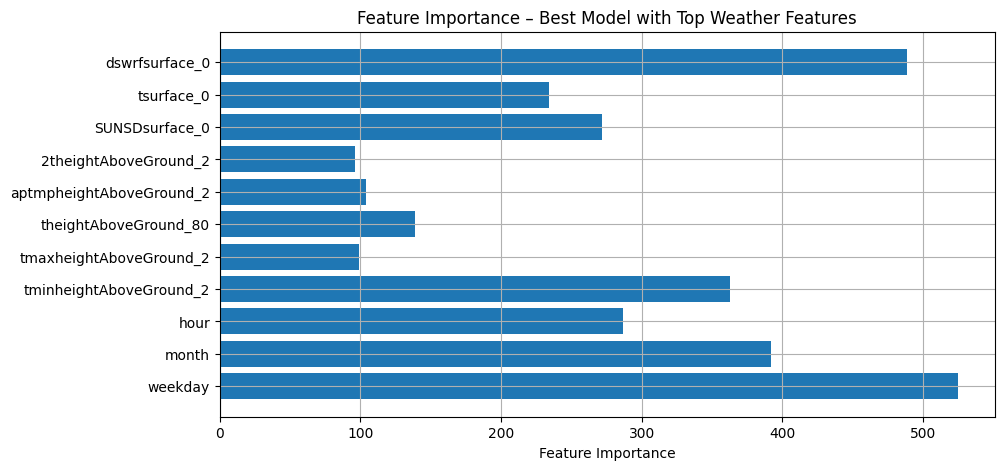

In [155]:
import matplotlib.pyplot as plt

importances = best_model_df1.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(best_features, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance – Best Model with Top Weather Features")
plt.gca().invert_yaxis()
plt.grid()
plt.show()
